In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests

from fcd_torch import FCD
import torch

import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Loading the Data:
---

In [2]:
# checking the sizes of each of the different files to determine which one is the largest/the one I should use.
import os
directory = '/mnt/usb/cmdunham'
for filename in os.listdir(directory):
    if 'meta' in filename:
        file_path = os.path.join(directory, filename)
        data = pd.read_feather(file_path)
        file = filename.split('.')[0]
        print(f'There are {data.shape[0]:,} samples in the {file} files.')

There are 60,489 samples in the MES_JP8_ims_acbc_train_v1 files.
There are 282,508 samples in the BKG_DMMP_ims_acbc_train_v1 files.
There are 599,528 samples in the BKG_SIM_ims_acbc_train_v1 files.


In [2]:
filename = '/mnt/usb/cmdunham/BKG_SIM_ims_acbc_train_v1.1.09_meta.feather'
metadata = pd.read_feather(filename)

filename = '/mnt/usb/cmdunham/BKG_SIM_ims_acbc_train_v1.1.09_spectra.feather'
spectra = pd.read_feather(filename)

The 'level_0' column of the metadata dataframe can be matched with the 'index' column of the spectra dataframe to identify metadata for each sample.

In [21]:
metadata.head()

,level_0,index,Filename,TemperatureKelvin,PressureBar,PosPeak1Mobility,PosPeak2Mobility,PosPeak3Mobility,PosPeak1Amplitude,PosPeak2Amplitude,PosPeak3Amplitude,NegPeak1Mobility,NegPeak2Mobility,NegPeak3Mobility,NegPeak1Amplitude,NegPeak2Amplitude,NegPeak3Amplitude,Label
0,374419,0,JCAD_0053_2022-01-20-09-27-47_2022-01-20-14-27...,NaN,1019.5,2.290,0.0,0.0,7776.0,0.0,0.0,2.129,0.0,0.0,7279.0,0.0,0.0,BKG
1,531524,0,IMS_VX_90%_0053_2022-04-25-09-10-20_2022-04-25...,NaN,1020.3,2.283,0.0,0.0,7530.0,0.0,0.0,2.118,0.0,0.0,7062.0,0.0,0.0,BKG
2,315950,0,JCAD_0053_2022-01-20-09-34-32_2022-01-20-14-34...,NaN,1019.5,2.291,0.0,0.0,7690.0,0.0,0.0,2.130,0.0,0.0,7317.0,0.0,0.0,BKG
3,374517,0,JCAD_0053_2022-01-20-09-24-09_2022-01-20-14-24...,NaN,1019.5,2.291,0.0,0.0,7796.0,0.0,0.0,2.129,0.0,0.0,7312.0,0.0,0.0,BKG
4,374610,0,JCAD_0053_2022-01-20-09-17-04_2022-01-20-14-17...,NaN,1019.2,2.289,0.0,0.0,7682.0,0.0,0.0,2.128,0.0,0.0,7373.0,0.0,0.0,BKG


In [22]:
spectra.head()

,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,...,n_1013,n_1014,n_1015,n_1016,n_1017,n_1018,n_1019,n_1020,n_1021,Label
0,1427,92.0,94.0,98.0,101.0,106.0,110.0,117.0,121.0,127.0,...,-11.0,-11.0,-11.0,-8.0,-8.0,-7.0,-7.0,-7.0,-7.0,BKG
1,1452,85.0,87.0,92.0,98.0,103.0,110.0,116.0,123.0,127.0,...,-13.0,-14.0,-17.0,-18.0,-19.0,-20.0,-17.0,-17.0,-17.0,BKG
2,1467,86.0,91.0,97.0,103.0,109.0,115.0,120.0,125.0,130.0,...,-18.0,-18.0,-22.0,-22.0,-24.0,-23.0,-23.0,-23.0,-21.0,BKG
3,1486,97.0,98.0,102.0,104.0,107.0,110.0,114.0,117.0,121.0,...,-27.0,-26.0,-26.0,-22.0,-21.0,-22.0,-23.0,-23.0,-27.0,BKG
4,1564,91.0,96.0,101.0,105.0,112.0,117.0,121.0,125.0,128.0,...,-14.0,-17.0,-18.0,-21.0,-21.0,-19.0,-18.0,-17.0,-16.0,BKG


In [6]:
metadata.shape

(599528, 18)

In [7]:
print('Number of unique values in each field:')
print('   Label: ', len(set(metadata['Label'])))
print('   PressureBar: ', len(set(metadata['PressureBar'])))
print('   TemperatureKelvin: ', len(set(metadata['TemperatureKelvin'])))

Number of unique values in each field:
   Label:  9
   PressureBar:  798
   TemperatureKelvin:  667


In [8]:
unique_labels = metadata['Label'].unique()
print(f'There are {len(unique_labels)} unique labels in the metadata DataFrame.')
print('----------------------------------------------------')
labels_counts = metadata['Label'].value_counts()
for label in labels_counts.index:
  print(f'There are {labels_counts[label]:,} samples for the {label} label.')

There are 9 unique labels in the metadata DataFrame.
----------------------------------------------------
There are 228,663 samples for the BKG label.
There are 132,517 samples for the TEPO label.
There are 53,845 samples for the DMMP label.
There are 51,545 samples for the MES label.
There are 51,533 samples for the DEM label.
There are 30,514 samples for the DEB label.
There are 22,404 samples for the DtBP label.
There are 19,563 samples for the DPM label.
There are 8,944 samples for the JP8 label.


In [9]:
metadata.isna().sum()

level_0               0
index                 0
Filename              0
TemperatureKelvin    13
PressureBar           0
PosPeak1Mobility      0
PosPeak2Mobility      0
PosPeak3Mobility      0
PosPeak1Amplitude     0
PosPeak2Amplitude     0
PosPeak3Amplitude     0
NegPeak1Mobility      0
NegPeak2Mobility      0
NegPeak3Mobility      0
NegPeak1Amplitude     0
NegPeak2Amplitude     0
NegPeak3Amplitude     0
Label                 0
dtype: int64

In [10]:
# # dropping the 13 rows with NaN values in "TemperatureKelvin" field.
# metadata = metadata.dropna(subset='TemperatureKelvin')

# Plotting variation within numeric features:
---

In [11]:
numeric_features = [col for col in metadata.columns if metadata[col].dtype == np.float64]

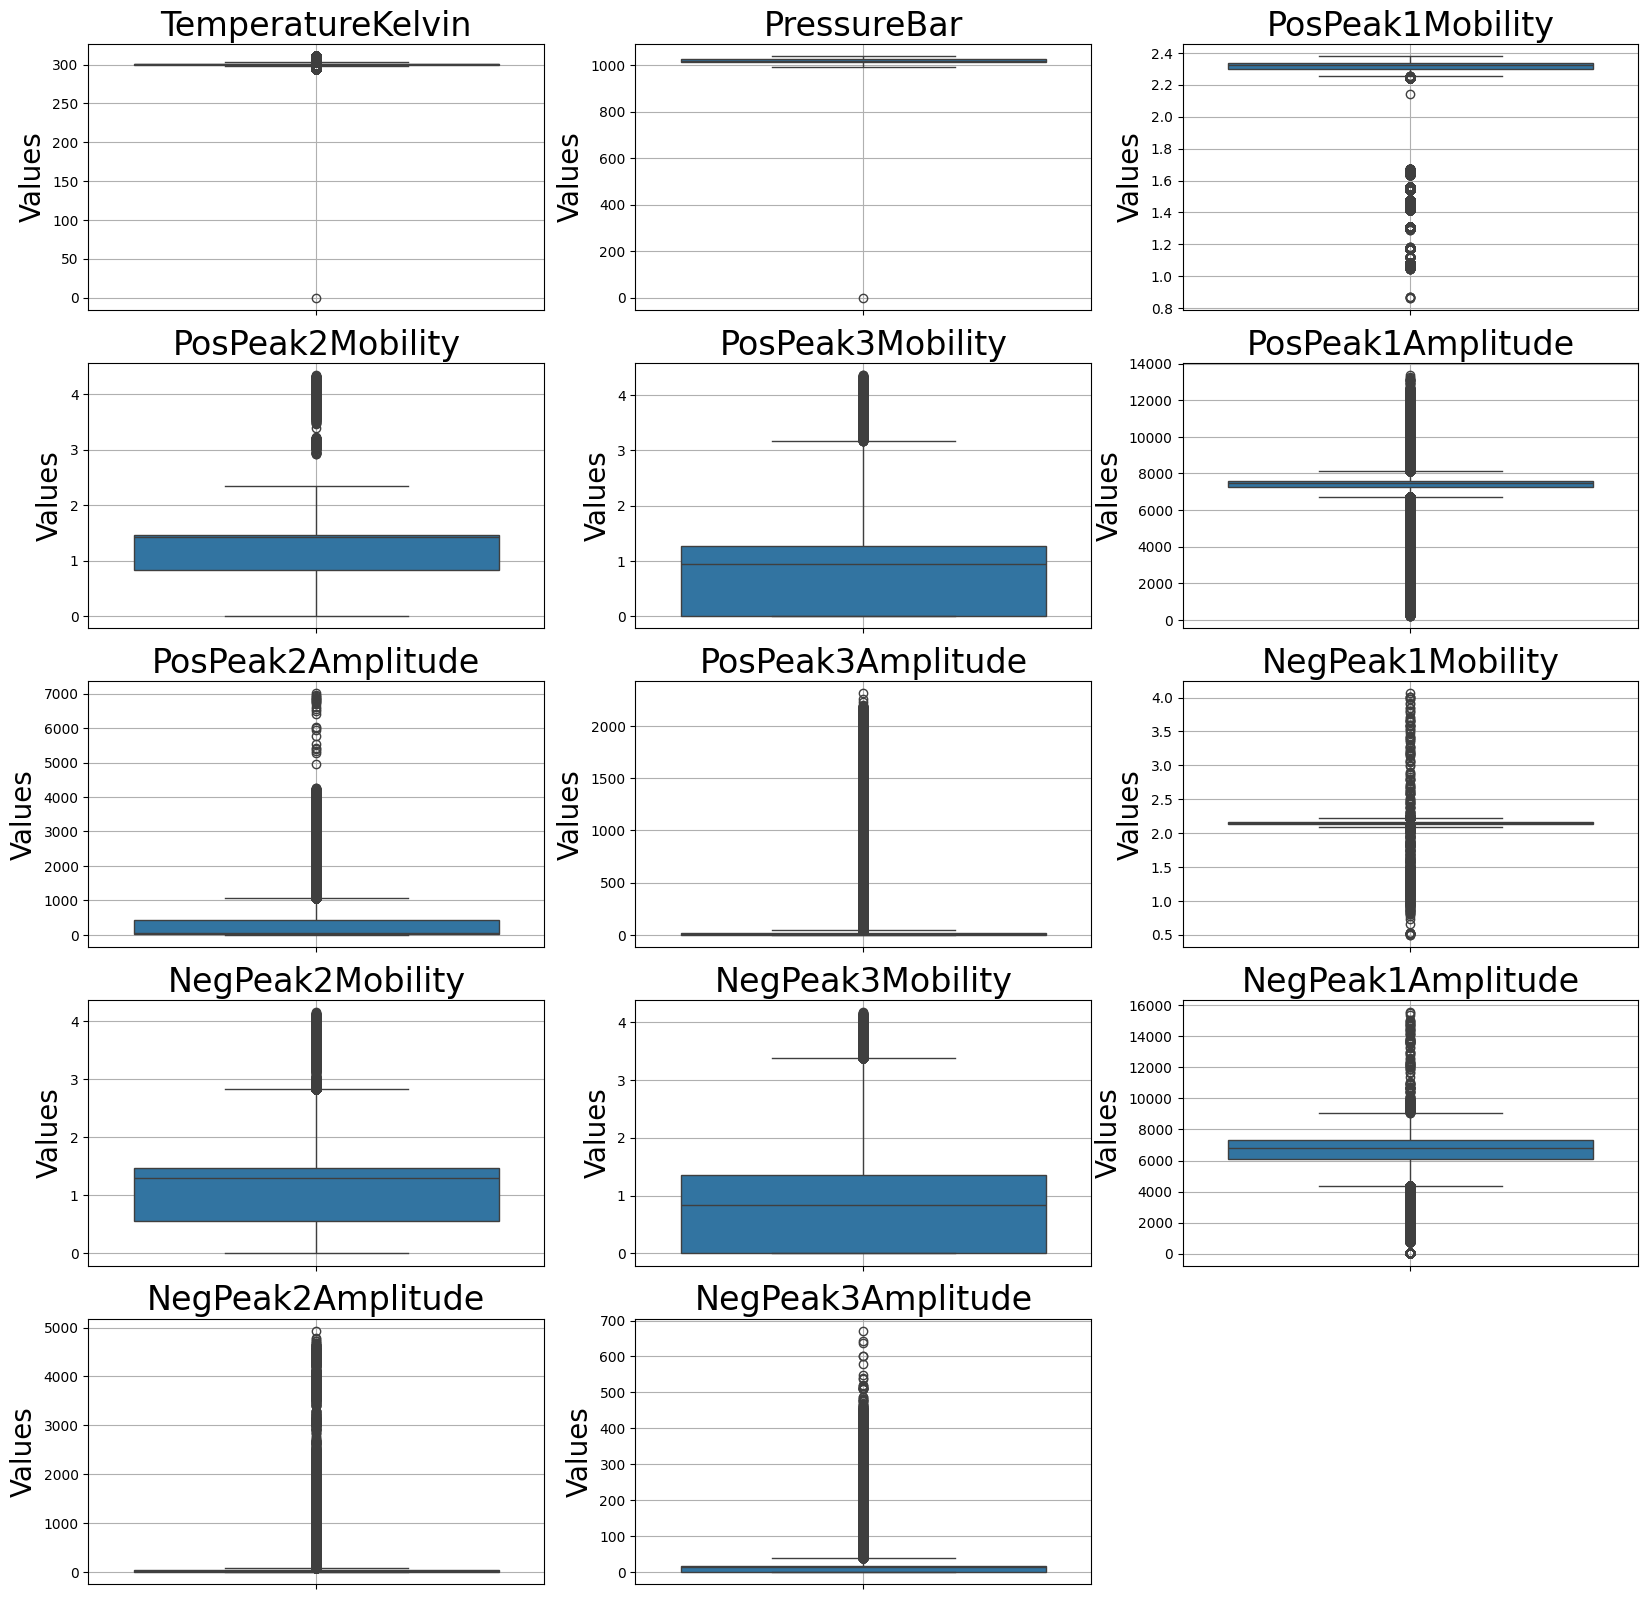

In [12]:
num_features = len(numeric_features)
cols = 3  # Number of columns for the subplots
rows = (num_features + cols - 1) // cols  # Calculate number of rows needed
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.boxplot(ax=axes[i], y=metadata[feature])
    axes[i].set_title(feature,fontsize=24)
    axes[i].set_ylabel('Values', fontsize=20)
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

In the boxplots above we can see that "TemperatureKelvin" and "PressureBar" fields have significant outliers. I'll drop those samples.

In [13]:
# removing outliers from two fields
metadata_cleaned = metadata[metadata["TemperatureKelvin"] > 0]
metadata_cleaned = metadata_cleaned[metadata_cleaned["PressureBar"] > 0]
print(f'Dropping outliers from "TemperatureKelvin" and "PressureBar" removed {metadata.shape[0] - metadata_cleaned.shape[0]} rows from the dataset.') 

Dropping outliers from "TemperatureKelvin" and "PressureBar" removed 14 rows from the dataset.


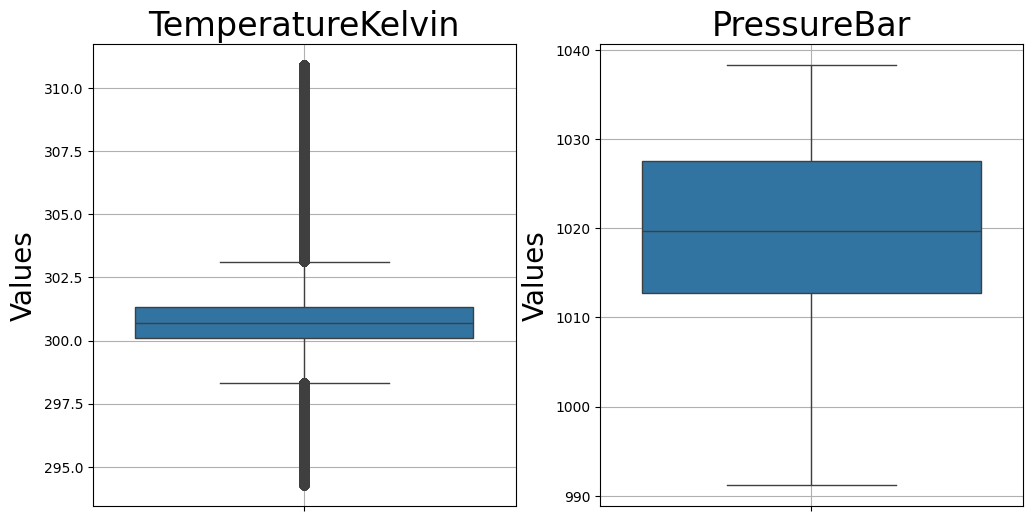

In [14]:
features = ['TemperatureKelvin', 'PressureBar']
cols = len(features)  # Number of columns for the subplots
fig, axes = plt.subplots(1, cols, figsize=(12, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(ax=axes[i], y=metadata_cleaned[feature])
    axes[i].set_title(feature,fontsize=24)
    axes[i].set_ylabel('Values', fontsize=20)
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

The boxplots for these features no longer show significant outliers.

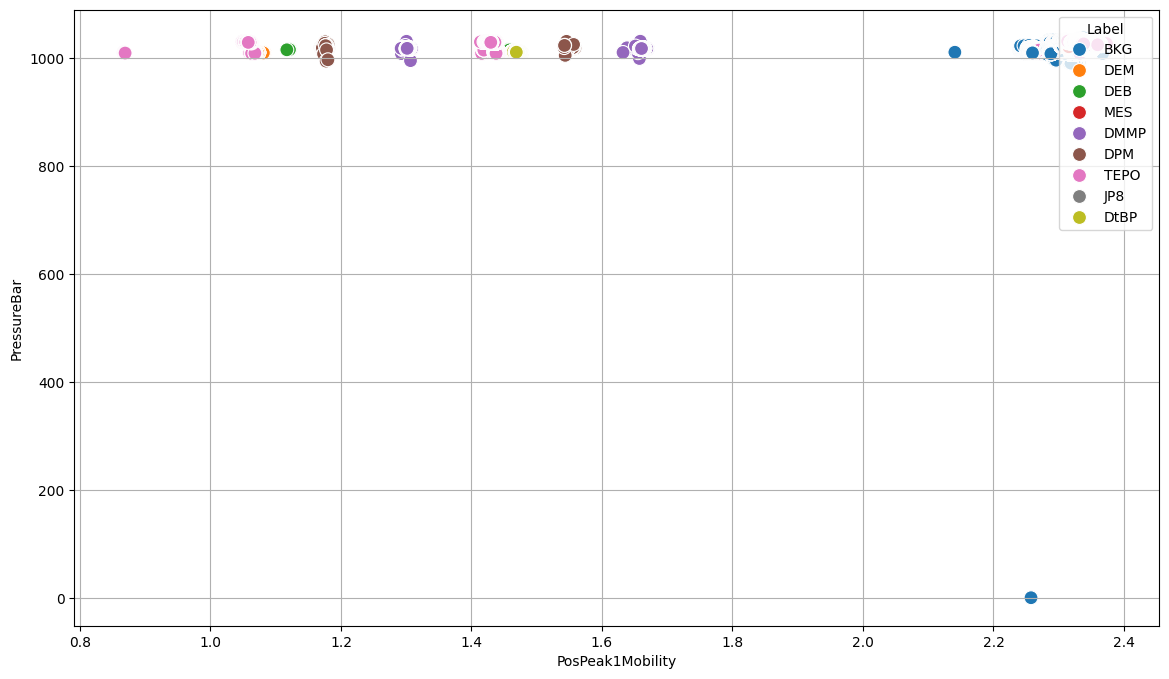

In [15]:
fig, ax = plt.subplots(figsize=(14, 8))

# Plot only a section of the df if a plot of the entire thing is difficult to interpret
# slice_num = 300
# sns.scatterplot(data=metadata[:][:slice_num], x='PosPeak1Mobility', y='Label', hue='Label', legend="brief", ax=ax, s=100)

# sns.scatterplot(data=metadata, x='PosPeak1Mobility', y='Label', hue='Label', legend="brief", ax=ax, s=100)
sns.scatterplot(data=metadata, x='PosPeak1Mobility', y='PressureBar', hue='Label', legend="brief", ax=ax, s=100)
sns.move_legend(ax, 'upper right')

# plt.xticks([])
# plt.xlabel('Collision Cross Section Average', fontsize=16)
# plt.ylabel('Molecular Formula', fontsize=16)
# plt.title('CCS Average Values Across Molecules', fontsize=20)
plt.grid()
plt.show()

# Plotting IMS Spectra:
---

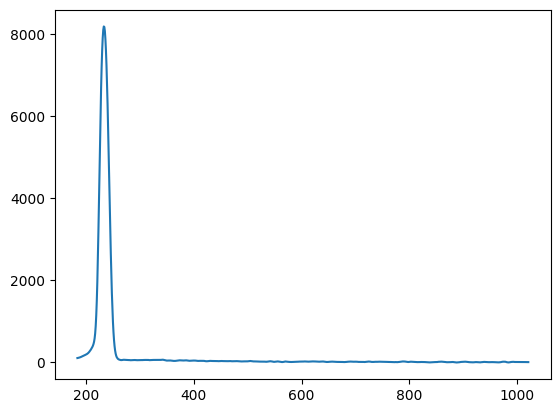

In [16]:
ims_spectra_data = spectra.drop(columns=['index', 'Label'])

x_p_vals = [int(col.split('_')[1]) for col in ims_spectra_data.columns if col.split('_')[0] == 'p']
# x_n_vals = [int(col.split('_')[1]) for col in ims_spectra_data.columns if col.split('_')[0] == 'n']

plt.plot(x_p_vals, ims_spectra_data.iloc[0][:len(x_p_vals)])
# plt.plot(x_n_vals, ims_spectra_data.iloc[0][len(x_p_vals):])
plt.show()

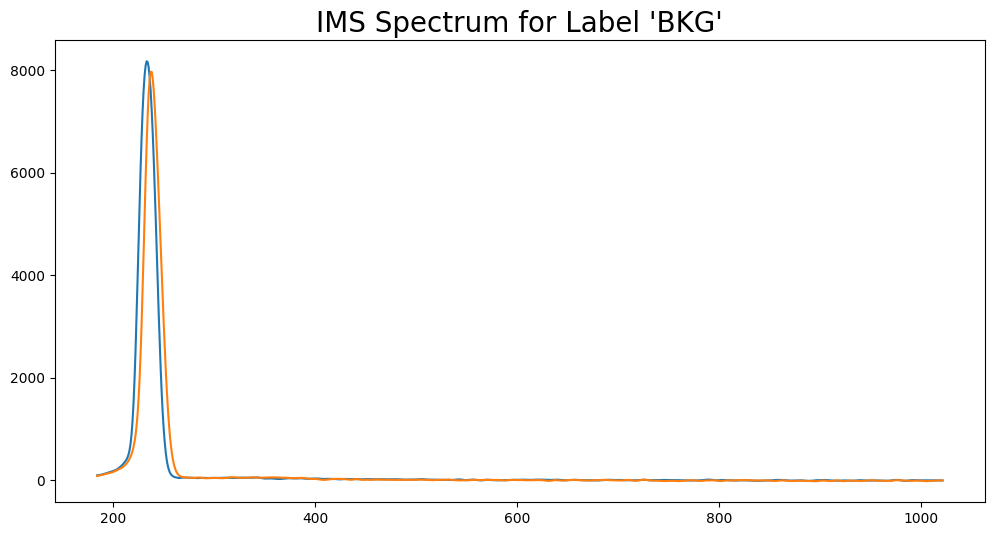

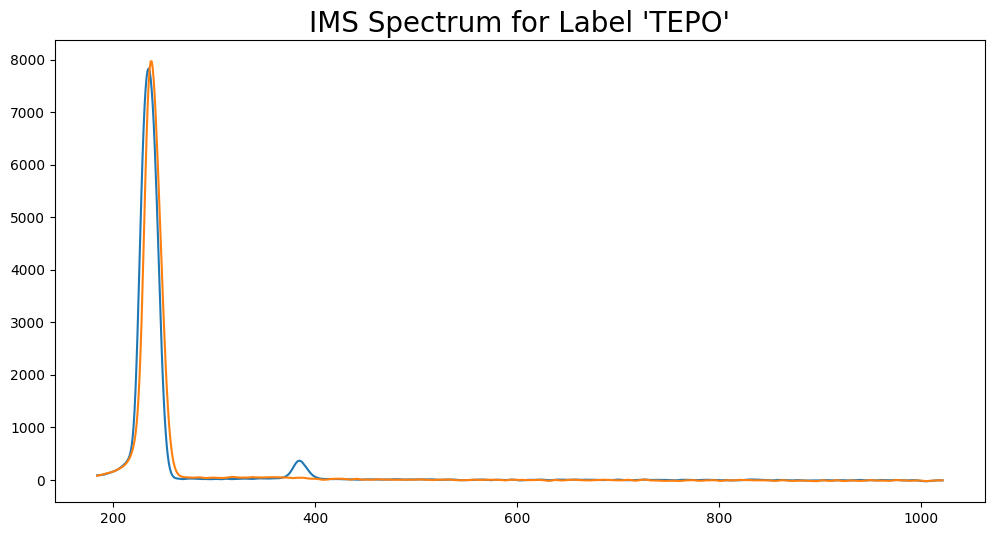

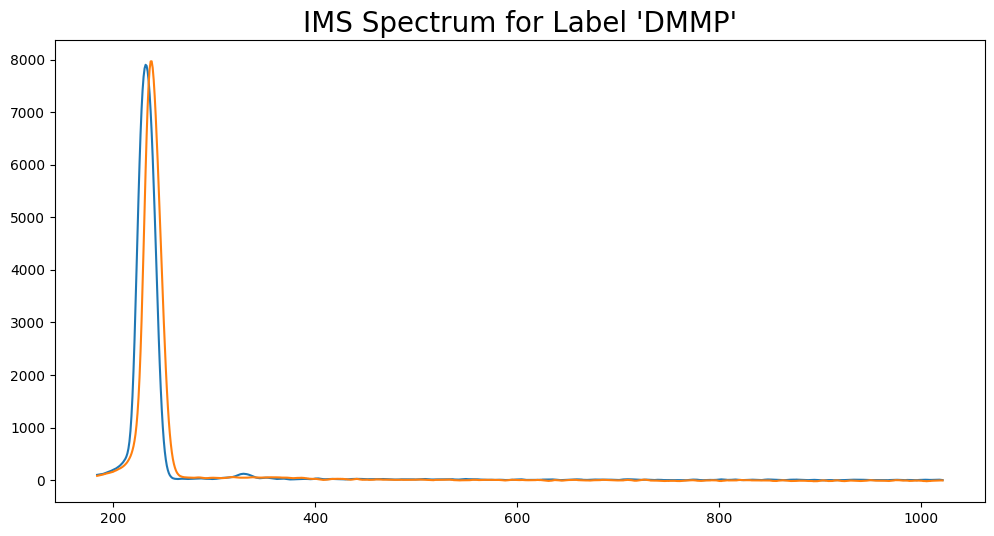

In [17]:
# Plotting spectra for a few different labels
ims_spectra_data = spectra.drop(columns=['index', 'Label'])
labels = spectra['Label']

# column names are currently in the format 'p_1234' or 'n_1234'. Separating into two lists for labeling the x-axis
x_p_vals = [int(col.split('_')[1]) for col in ims_spectra_data.columns if col.split('_')[0] == 'p']
x_n_vals = [int(col.split('_')[1]) for col in ims_spectra_data.columns if col.split('_')[0] == 'n']

plotting_indices = [0, 450000, 460000]
for idx in plotting_indices:
    plt.figure(figsize=(12, 6))
    plt.plot(x_p_vals, ims_spectra_data.iloc[idx][:len(x_p_vals)])
    plt.plot(x_n_vals, ims_spectra_data.iloc[0][len(x_p_vals):])
    plt.title(f"IMS Spectrum for Label '{labels[idx]}'", fontsize=20)
    plt.show()

In [18]:
ims_spectra_data = spectra.drop(columns=['index', 'Label'])
labels = spectra['Label']

# column names are currently in the format 'p_1234' or 'n_1234'. Separating into two lists for labeling the x-axis
x_p_vals = [int(col.split('_')[1]) for col in ims_spectra_data.columns if col.split('_')[0] == 'p']
x_n_vals = [int(col.split('_')[1]) for col in ims_spectra_data.columns if col.split('_')[0] == 'n']



completed = []
for idx in range(len(labels)):
    if labels[idx] not in completed:

        print(f'Details for {labels[idx]} spectrum:')
        # all of the spectra look very similar visually. I'm curious about the differences in their highest peak locations
        highest_val = max(ims_spectra_data.iloc[idx][:len(x_p_vals)])
        higest_val_idx = list(ims_spectra_data.iloc[idx]).index(highest_val)
        print(f'  Highest p: {round(max(ims_spectra_data.iloc[idx][:len(x_p_vals)])):,} at p = {x_p_vals[higest_val_idx]}')
        # print(f'Higest val at p = {x_p_vals[higest_val_idx]}')

        print('  -----------------')

        # print(f'Highest n: {round(max(ims_spectra_data.iloc[idx][len(x_p_vals):])):,}')
        highest_val = max(ims_spectra_data.iloc[idx][:len(x_n_vals)])
        higest_val_idx = list(ims_spectra_data.iloc[idx]).index(highest_val)
        print(f'  Highest n: {round(max(ims_spectra_data.iloc[idx][len(x_p_vals):])):,} at n = {x_n_vals[higest_val_idx]}')

        print('---------------------')
        print('---------------------')

        completed.append(labels[idx])

Details for BKG spectrum:
  Highest p: 8,178 at p = 233
  -----------------
  Highest n: 7,971 at n = 233
---------------------
---------------------
Details for MES spectrum:
  Highest p: 8,037 at p = 233
  -----------------
  Highest n: 4,777 at n = 233
---------------------
---------------------
Details for DEM spectrum:
  Highest p: 5,576 at p = 229
  -----------------
  Highest n: 5,611 at n = 229
---------------------
---------------------
Details for DEB spectrum:
  Highest p: 7,936 at p = 230
  -----------------
  Highest n: 7,332 at n = 230
---------------------
---------------------
Details for JP8 spectrum:
  Highest p: 8,164 at p = 228
  -----------------
  Highest n: 6,056 at n = 228
---------------------
---------------------
Details for DPM spectrum:
  Highest p: 7,454 at p = 227
  -----------------
  Highest n: 7,478 at n = 227
---------------------
---------------------
Details for DtBP spectrum:
  Highest p: 7,774 at p = 234
  -----------------
  Highest n: 7,677 at n

# Getting Simulant Names/SMILES:
---

In [19]:
labels = list(metadata['Label'].unique())
labels

['BKG', 'DEM', 'DEB', 'MES', 'DMMP', 'DPM', 'TEPO', 'JP8', 'DtBP']

In [9]:
simulant_name_mapping = {'BKG':{'Name':'background', 'SMILES':'NA'}, 'DEM':{'Name': 'Diethyl Malonate'}, 'DEB':{'Name': '1,2,3,4-Diepoxybutane' }, 
                         'MES':{'Name': '2-(N-morpholino)ethanesulfonic acid'}, 'DMMP':{'Name': 'Dimethyl methylphosphonate'}, 'DPM':{'Name': 'Oxybispropanol'}, 
                         'JP8':{'Name': 'JP8'}, 'TEPO':{'Name': 'Triethyl phosphate', 'SMILES': 'CCOP(=O)(OCC)OCC'},'DtBP':{'Name': 'Di-tert-butyl peroxide', 'SMILES': 'O(OC(C)(C)C)C(C)(C)C'}}
names = []
for key in simulant_name_mapping:
    names.append(simulant_name_mapping[key]['Name'])


In [10]:
# get the corresponding SMILES for each simulant name in the dataset and store in a dict
# smiles_dict = {}
# for name in names:

for abbreviation in simulant_name_mapping:
    name = simulant_name_mapping[abbreviation]['Name']
    try:
        # send simulant name to PubChem's API and get SMILES out of response
        url = (f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/property/CanonicalSMILES/JSON')
        r = requests.get(url).json()
        smiles = r['PropertyTable']['Properties'][0]['CanonicalSMILES']
        # smiles_dict[name] = smiles
        simulant_name_mapping[abbreviation]['SMILES'] = smiles

    except KeyError as e:
        try:
            # send simulant abbreviation to PubChem's API and get SMILES out of response
            url = (f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{abbreviation}/property/CanonicalSMILES/JSON')
            r = requests.get(url).json()
            smiles = r['PropertyTable']['Properties'][0]['CanonicalSMILES']
            simulant_name_mapping[abbreviation]['SMILES'] = smiles
        except KeyError as e:
            if e == 'PropertyTable':
                simulant_name_mapping[abbreviation]['SMILES'] = 'unknown'

# print(smiles_dict)
simulant_name_mapping

{'BKG': {'Name': 'background', 'SMILES': 'NA'},
 'DEM': {'Name': 'Diethyl Malonate', 'SMILES': 'CCOC(=O)CC(=O)OCC'},
 'DEB': {'Name': '1,2,3,4-Diepoxybutane', 'SMILES': 'C1C(O1)C2CO2'},
 'MES': {'Name': '2-(N-morpholino)ethanesulfonic acid',
  'SMILES': 'C1COCCN1CCS(=O)(=O)O'},
 'DMMP': {'Name': 'Dimethyl methylphosphonate', 'SMILES': 'COP(=O)(C)OC'},
 'DPM': {'Name': 'Oxybispropanol', 'SMILES': 'CC(CO)OC(C)CO.CC(COCC(C)O)O'},
 'JP8': {'Name': 'JP8', 'SMILES': 'C1CC(NC1)COC(=O)NC2CCC(=O)NC2=O'},
 'TEPO': {'Name': 'Triethyl phosphate', 'SMILES': 'CCOP(=O)(OCC)OCC'},
 'DtBP': {'Name': 'Di-tert-butyl peroxide', 'SMILES': 'CC(C)(C)OOC(C)(C)C'}}

# Getting Simulant ChemNet Embeddings:
---

In [11]:
# use SMILES to get ChemNet embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fcd = FCD(device, n_jobs=1)
for abbreviation in simulant_name_mapping:
    if abbreviation != 'BKG':
        smiles = simulant_name_mapping[abbreviation]['SMILES']
        simulant_name_mapping[abbreviation]['embedding'] = list(fcd.get_predictions([smiles])[0])

# Saving Spectra and Embedding Files:
---

## Spectra:
---

In [4]:
# Remove all background spectra, leave only simulants
simulants = spectra[spectra['Label'] != 'BKG']

# Create OneHot encodings of chem abbreviations
enc = OneHotEncoder(sparse_output=False)
encodings = enc.fit_transform(simulants[['Label']])

# get chemical abbreviations from enc.categories
columns = [abbr for abbr in enc.categories_[0]]
# create encoding df 
encoding_df = pd.DataFrame(encodings, columns=columns)

In [7]:
# dropping indices so concatenation works correctly  
simulants.reset_index(drop=True, inplace=True)
encoding_df.reset_index(drop=True, inplace=True)

# concatenate simulants and encoding df
spectra_and_encodings = pd.concat([simulants, encoding_df], axis=1)
spectra_and_encodings

,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,316161,99.0,103.0,106.0,111.0,116.0,121.0,125.0,130.0,136.0,...,-26.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,316163,83.0,87.0,92.0,95.0,100.0,104.0,109.0,114.0,120.0,...,8.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,316164,91.0,95.0,97.0,101.0,107.0,113.0,120.0,128.0,134.0,...,7.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,316165,87.0,91.0,95.0,99.0,103.0,107.0,111.0,119.0,126.0,...,-13.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,316166,75.0,79.0,82.0,87.0,94.0,100.0,107.0,112.0,118.0,...,-2.0,MES,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370860,1525853,86.0,90.0,94.0,98.0,102.0,106.0,109.0,111.0,114.0,...,-1.0,DPM,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
370861,1525856,85.0,89.0,95.0,100.0,105.0,109.0,114.0,117.0,120.0,...,-18.0,DPM,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
370862,1525859,82.0,85.0,91.0,95.0,101.0,105.0,108.0,111.0,113.0,...,-4.0,DPM,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
370863,1525861,78.0,81.0,83.0,86.0,89.0,92.0,96.0,100.0,104.0,...,-6.0,DPM,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:
# divide into train and test data
train, test = train_test_split(spectra_and_encodings, test_size=.2, random_state = 42)
# divide train into train and validation data
train, val = train_test_split(train, test_size=.1, random_state=42)

In [26]:
file_path = '../data/train_data.csv'

file_path = '../data/test_data.csv'
test.to_csv(file_path)
# # List of tuples containing DataFrames and their corresponding names
# data_splits = [(train, 'train'), (val, 'val'), (test, 'test')]

# # Iterate through the DataFrames and their names
# for split, name in data_splits:
#     filename = name + '.csv'
#     file_path = os.path.join(dir, filename)
#     split.to_csv(file_path)

## Embeddings:
---

In [16]:
name_smiles_embedding_df = pd.DataFrame(simulant_name_mapping).T
name_smiles_embedding_df.head()

,Name,SMILES,embedding
BKG,background,NA,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


In [19]:
# save df with chem names, smiles and ChemNet embeddings
file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df.to_csv(file_path)